<a href="https://colab.research.google.com/github/yaroslav711/nst/blob/master/course_work.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Нейросеть стилизующая изображения

Кануков Денис Михайлович БИВ201

Москаленко Ярослав Александрович БИВ201

Перед запуском алгоритма рекомендуется перевести вычисления на графический процессор. Он предусмотрен в Google Colab. Для перевода вычислений необходимо перейти в Runtme -> Change Runtime type, затем установить Hardware accelerator на GPU. Это сократит время работы алгоритма.

Чтобы запустить код целиком необходимо нажать Runtime -> Runtime all

In [1]:
#подключение необходимых библиотек
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from google.colab import files
from io import BytesIO
from PIL import Image
import cv2


In [2]:
#загрузка изображений. Для загрузки необходимо подавать файлы с названиями img.jpg для изображения и img_style.jpg для стиля
upl = files.upload()
img = Image.open(BytesIO(upl['img.jpg']))
style = Image.open(BytesIO(upl['img_style.jpg']))

Saving img.jpg to img (2).jpg
Saving img_style.jpg to img_style (2).jpg


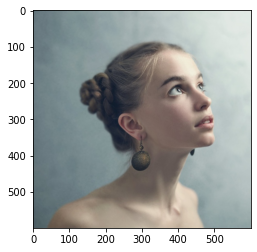

In [3]:
#вывод изображения
plt.imshow(img)

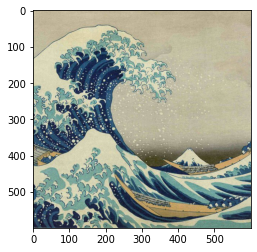

In [4]:
#вывод изображения со стилем
plt.imshow(style)

In [5]:
#предобработка изображений и загрузка в сверточную нейронную сеть VGG19
#после предобработки изображения принимают формат BGR, вместо привычного нам RGB
x_img = tf.keras.applications.vgg19.preprocess_input(np.expand_dims(img, axis = 0))
x_style = tf.keras.applications.vgg19.preprocess_input(np.expand_dims(style, axis = 0))

In [6]:
#Функция перевода изображения из BGR в RGB
def deprocess_img(processed_img):
  x = processed_img.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x, 0)
  assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                             "dimension [1, height, width, channel] or [height, width, channel]")
  if len(x.shape) != 3:
    raise ValueError("Invalid input to deprocessing image")
  
  # perform the inverse of the preprocessing step
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1]

  x = np.clip(x, 0, 255).astype('uint8')
  return x

In [7]:
#Используем предобученную нейронную сеть VGG19 с собственными весами и сделаем эти веса необучаемыми
vgg = keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
vgg.trainable = False 

In [8]:
#Создадим коллекции с названиями слоев, необходимых для дальнейшего выделения их из сети VGG19. Данные слои помогут в оценке лосса.
content_layers = ['block5_conv2'] 


style_layers = ['block1_conv1',
            'block2_conv1',
            'block3_conv1', 
            'block4_conv1', 
            'block5_conv1']        

In [9]:
#Количество необходимых слоев для стиля\контента
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

#Создадим и выделим в модель список тензоров для стиля, контента и общий список необходимых тензоров
style_outputs = [vgg.get_layer(name).output for name in style_layers]
content_outputs = [vgg.get_layer(name).output for name in content_layers]
model_outputs = style_outputs + content_outputs
model = keras.models.Model(vgg.input, model_outputs)

In [10]:
#Функция, возвращает фичи (выходы модели)
def get_feature_representations(model):
  style_outputs = model(x_style)
  content_outputs = model(x_img)
  
  style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
  content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]]
  return style_features, content_features

#Функция считает и возвращает среднеквадратичное отклонение (Content Loss/ потери по контенту). Самая простая и удобная метрика
def get_content_loss(base_content, target):
  return tf.reduce_mean(tf.square(base_content - target))

#Функция составляет матрицу Грамма для выбранного тензора. Матрица нам понадобится дальше для вычисления Style Loss/ Потерь по стилю
#Матрица Грамма G = X * X.T
def gram_matrix(input_tensor): 
  channels = int(input_tensor.shape[-1])
  a = tf.reshape(input_tensor, [-1, channels])
  n = tf.shape(a)[0]
  gram = tf.matmul(a, a, transpose_a=True)
  return gram / tf.cast(n, tf.float32)

#Функция возвращает потери по стилю путем подсчета среднеквадратичного отклонения матриц Грамма
def get_style_loss(base_style, gram_target):
  height, width, channels = base_style.get_shape().as_list()
  gram_style = gram_matrix(base_style)
  return tf.reduce_mean(tf.square(gram_style - gram_target))

#Функция подсчета общего лосса(потерь по стилю и контенту) для дальнейшей оптимизации.
def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
  style_weight, content_weight = loss_weights
  
  model_outputs = model(init_image)
  
  style_output_features = model_outputs[:num_style_layers]
  content_output_features = model_outputs[num_style_layers:]
  
  style_score = 0
  content_score = 0

  weight_per_style_layer = 1.0 / float(num_style_layers)
  for target_style, comb_style in zip(gram_style_features, style_output_features):
    style_score += weight_per_style_layer * get_style_loss(comb_style[0], target_style)
    
  weight_per_content_layer = 1.0 / float(num_content_layers)
  for target_content, comb_content in zip(content_features, content_output_features):
    content_score += weight_per_content_layer* get_content_loss(comb_content[0], target_content)
  
  style_score *= style_weight
  content_score *= content_weight

  loss = style_score + content_score 
  return loss, style_score, content_score

In [11]:
#Гиперпараметры полученные путем проб и ошибок))
#Кол-во итераций влияет на степень стилизации (чем больше - тем изображение больше соответсвует стилю, при этом потери по контенту растут. Необходимо найти золотую середину)
num_iterations=7500
content_weight=1e3
style_weight=1e-2

style_features, content_features = get_feature_representations(model)
gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]

init_image = np.copy(x_img)
init_image = tf.Variable(init_image, dtype=tf.float32)

#Создание оптимизатора Адам с гиперпараметрами полученными путем тех же проб и ошибок
opt = tf.compat.v1.train.AdamOptimizer(learning_rate=2, beta1=0.99, epsilon=1e-1)
iter_count = 1
best_loss, best_img = float('inf'), None
loss_weights = (style_weight, content_weight)

cfg = {
      'model': model,
      'loss_weights': loss_weights,
      'init_image': init_image,
      'gram_style_features': gram_style_features,
      'content_features': content_features
}

norm_means = np.array([103.939, 116.779, 123.68])
min_vals = -norm_means
max_vals = 255 - norm_means
imgs = []

#Запуск цикла оптимизации 
from tqdm import tqdm
for i in tqdm(range(num_iterations)):
    with tf.GradientTape() as tape: 
       all_loss = compute_loss(**cfg)
    loss, style_score, content_score = all_loss
    grads = tape.gradient(loss, init_image)

    opt.apply_gradients([(grads, init_image)])
    clipped = tf.clip_by_value(init_image, min_vals, max_vals)
    init_image.assign(clipped)
    
    if loss < best_loss:
      best_loss = loss
      best_img = deprocess_img(init_image.numpy())


      plot_img = deprocess_img(init_image.numpy())
      imgs.append(plot_img)

100%|██████████| 7500/7500 [30:04<00:00,  4.16it/s]


tf.Tensor(177616.83, shape=(), dtype=float32)


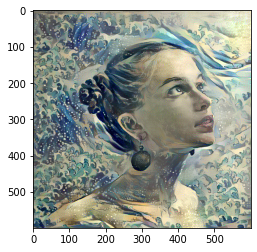

In [12]:
#Вывод получившегося (лучшего по потерям) изображения
plt.imshow(best_img)
print(best_loss)

Алгоритм работает как ожидалось. 